title: HNSCC_VisiumST_Deconvolution \
author: Emilia Puig Lombardi \
date: 2024-02-01

In [ ]:
#Environment setup
library(Seurat) #4.3.0
library(ggplot2)
library(dplyr)
library(tibble)
library(gridExtra)
library(tidyr)
#library(CARD)
library(SpaCET)
library(patchwork)

In [2]:
obj <- readRDS("19h1257-1_PP_preprocessed.rds")

## Pathologist annotations

In [3]:
# Label tumor/healthy spots adding pathologist annotations
patho.data <- read.table("Pathologist_annotation_MC_19H1257-1-PP.csv", sep=",",h=T, row.names=1)
head(patho.data)

Pathologist.Annotation.CB.19H1257.1.PP
AACACTTGGCAAGGAA-1 Infiltrative SCC                      
AACAGGATTCATAGTT-1 Infiltrative SCC                      
AACAGGTTATTGCACC-1 Infiltrative SCC                      
AACAGGTTCACCGAAG-1 inflamatory stroma                    
AACATCTAATGACCGG-1 Infiltrative SCC                      
AACCAAGGTATCAGGC-1 Infiltrative SCC

In [4]:
colnames(patho.data) <- "pathologist.annotations"

In [5]:
obj <- AddMetaData(obj,patho.data)
head(obj@meta.data)

orig.ident   nCount_Spatial nFeature_Spatial response
AACACTTGGCAAGGAA-1 19h1257-1_PP 30707          8949             NR      
AACAGGATTCATAGTT-1 19h1257-1_PP 26333          8419             NR      
AACAGGTTATTGCACC-1 19h1257-1_PP 16632          6095             NR      
AACAGGTTCACCGAAG-1 19h1257-1_PP 20990          6931             NR      
AACATCTAATGACCGG-1 19h1257-1_PP 22763          7336             NR      
AACCAAGGTATCAGGC-1 19h1257-1_PP 16951          6843             NR      
                   labels   percent.mito low_outliers high_outliers
AACACTTGGCAAGGAA-1 Selected 2.035367     FALSE        FALSE        
AACAGGATTCATAGTT-1 Selected 2.308890     FALSE        FALSE        
AACAGGTTATTGCACC-1 Selected 1.160414     FALSE        FALSE        
AACAGGTTCACCGAAG-1 Selected 1.257742     FALSE        FALSE        
AACATCTAATGACCGG-1 Selected 1.287177     FALSE        FALSE        
AACCAAGGTATCAGGC-1 Selected 3.368533     FALSE        FALSE        
                   LOG_low_outliers LOG_high_outliers ⋯ seurat_clusters
AACACTTGGCAAGGAA-1 FALSE            FALSE             ⋯ 0              
AACAGGATTCATAGTT-1 FALSE            FALSE             ⋯ 0              
AACAGGTTATTGCACC-1 FALSE            FALSE             ⋯ 3              
AACAGGTTCACCGAAG-1 FALSE            FALSE             ⋯ 3              
AACATCTAATGACCGG-1 FALSE            FALSE             ⋯ 2              
AACCAAGGTATCAGGC-1 FALSE            FALSE             ⋯ 7              
                   SCT_snn_res.0.3 SCT_snn_res.0.5 S.Score     G2M.Score  Phase
AACACTTGGCAAGGAA-1 0               0                0.05958682  0.3212029 G2M  
AACAGGATTCATAGTT-1 0               0               -0.05725855  0.1405744 G2M  
AACAGGTTATTGCACC-1 2               3               -0.37401155 -0.2439678 G1   
AACAGGTTCACCGAAG-1 2               3               -0.37595794 -0.2896387 G1   
AACATCTAATGACCGG-1 1               2               -0.32464648 -0.2756775 G1   
AACCAAGGTATCAGGC-1 0               7                0.03020539 -0.1221090 S    
                   old.ident Barcode            Cell_Phase
AACACTTGGCAAGGAA-1 0         AACACTTGGCAAGGAA-1 unassigned
AACAGGATTCATAGTT-1 0         AACAGGATTCATAGTT-1 unassigned
AACAGGTTATTGCACC-1 3         AACAGGTTATTGCACC-1 unassigned
AACAGGTTCACCGAAG-1 3         AACAGGTTCACCGAAG-1 unassigned
AACATCTAATGACCGG-1 2         AACATCTAATGACCGG-1 unassigned
AACCAAGGTATCAGGC-1 7         AACCAAGGTATCAGGC-1 unassigned
                   pathologist.annotations
AACACTTGGCAAGGAA-1 Infiltrative SCC       
AACAGGATTCATAGTT-1 Infiltrative SCC       
AACAGGTTATTGCACC-1 Infiltrative SCC       
AACAGGTTCACCGAAG-1 inflamatory stroma     
AACATCTAATGACCGG-1 Infiltrative SCC       
AACCAAGGTATCAGGC-1 Infiltrative SCC

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


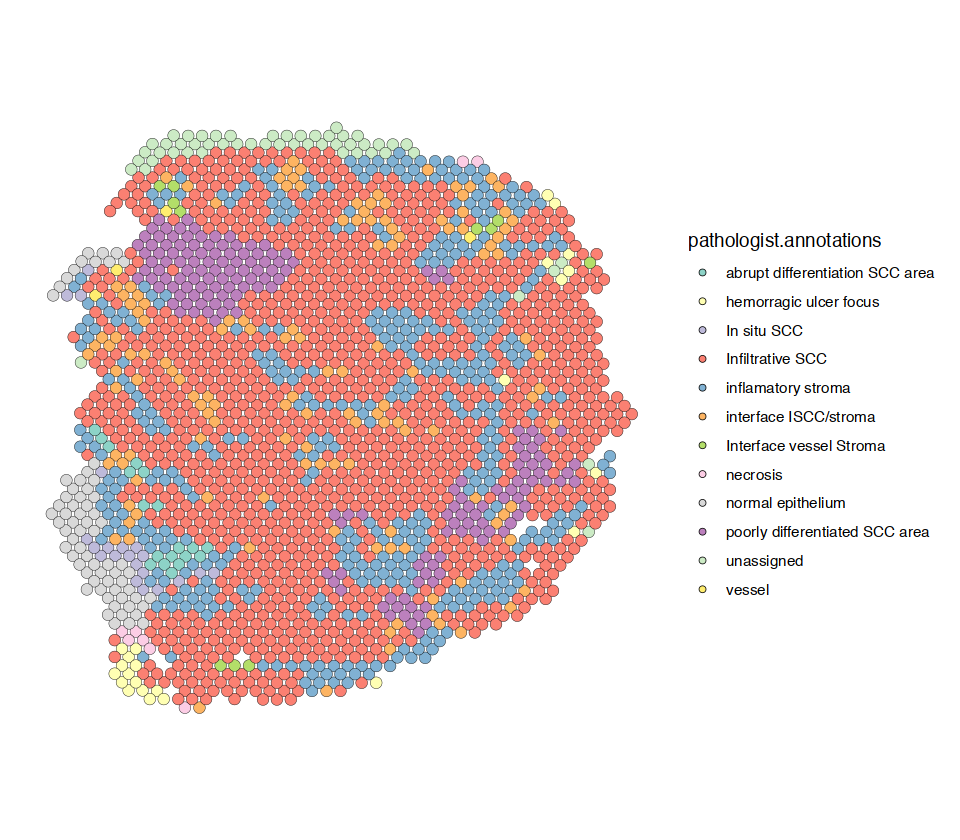

In [7]:
# plot sample annotations
options(repr.plot.width = 8, repr.plot.height = 7)
SpatialPlot(obj, group.by = "pathologist.annotations",pt.size=3, image.alpha=0) + 
scale_fill_brewer(palette="Set3") +
theme(legend.position = "right")

In [8]:
#Plots of number of read of each sample -> "Tumor" sample (grey) really high in features and counts and thus was excluded due to techinical processing issues 
plot1 <- VlnPlot(obj, features = "nCount_Spatial", group.by = "pathologist.annotations", pt.size = 0.5)  & theme(axis.title.x = element_blank())
plot2 <- SpatialFeaturePlot(obj, features = "nCount_Spatial", pt.size.factor = 2.5) + theme(legend.position = "right")
plot3 <- VlnPlot(obj, features = "nFeature_Spatial", group.by = "pathologist.annotations", pt.size = 0.5)  & theme(axis.title.x = element_blank())
plot4 <- SpatialFeaturePlot(obj, features = "nFeature_Spatial", pt.size.factor = 2.5) + theme(legend.position = "right")

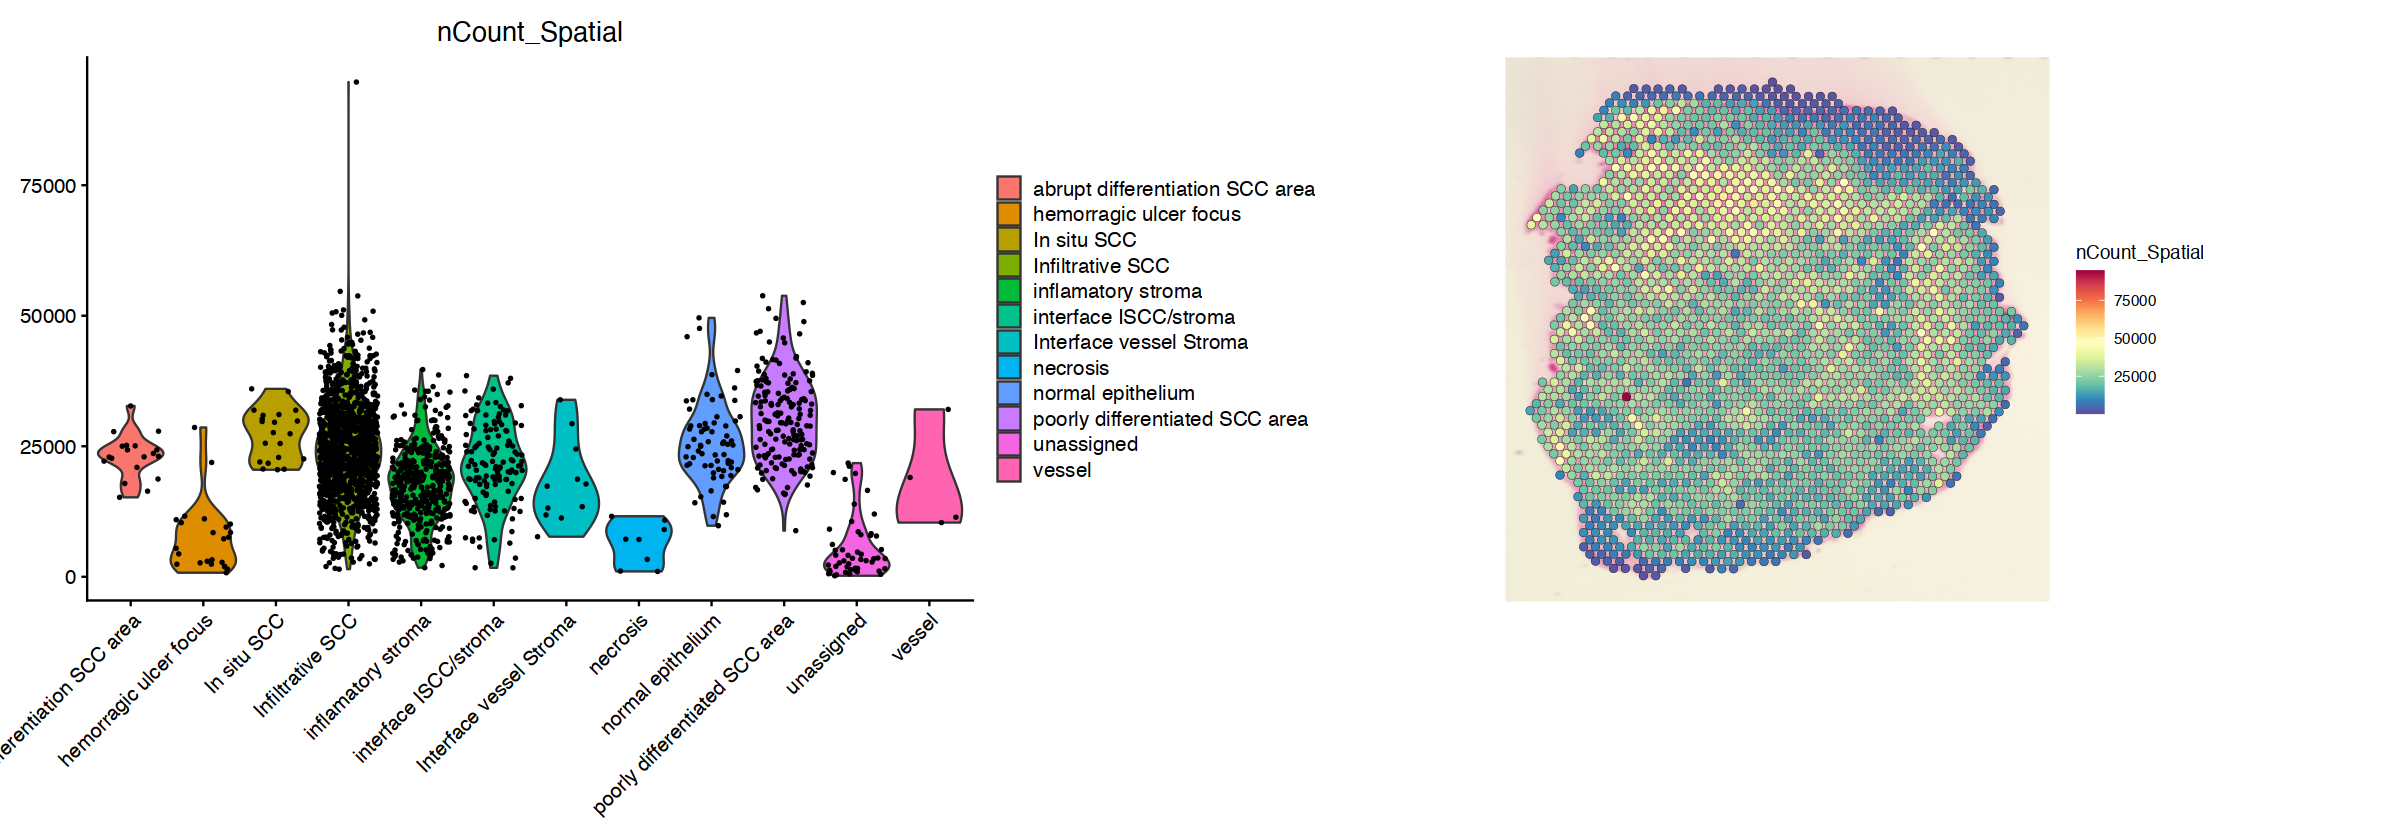

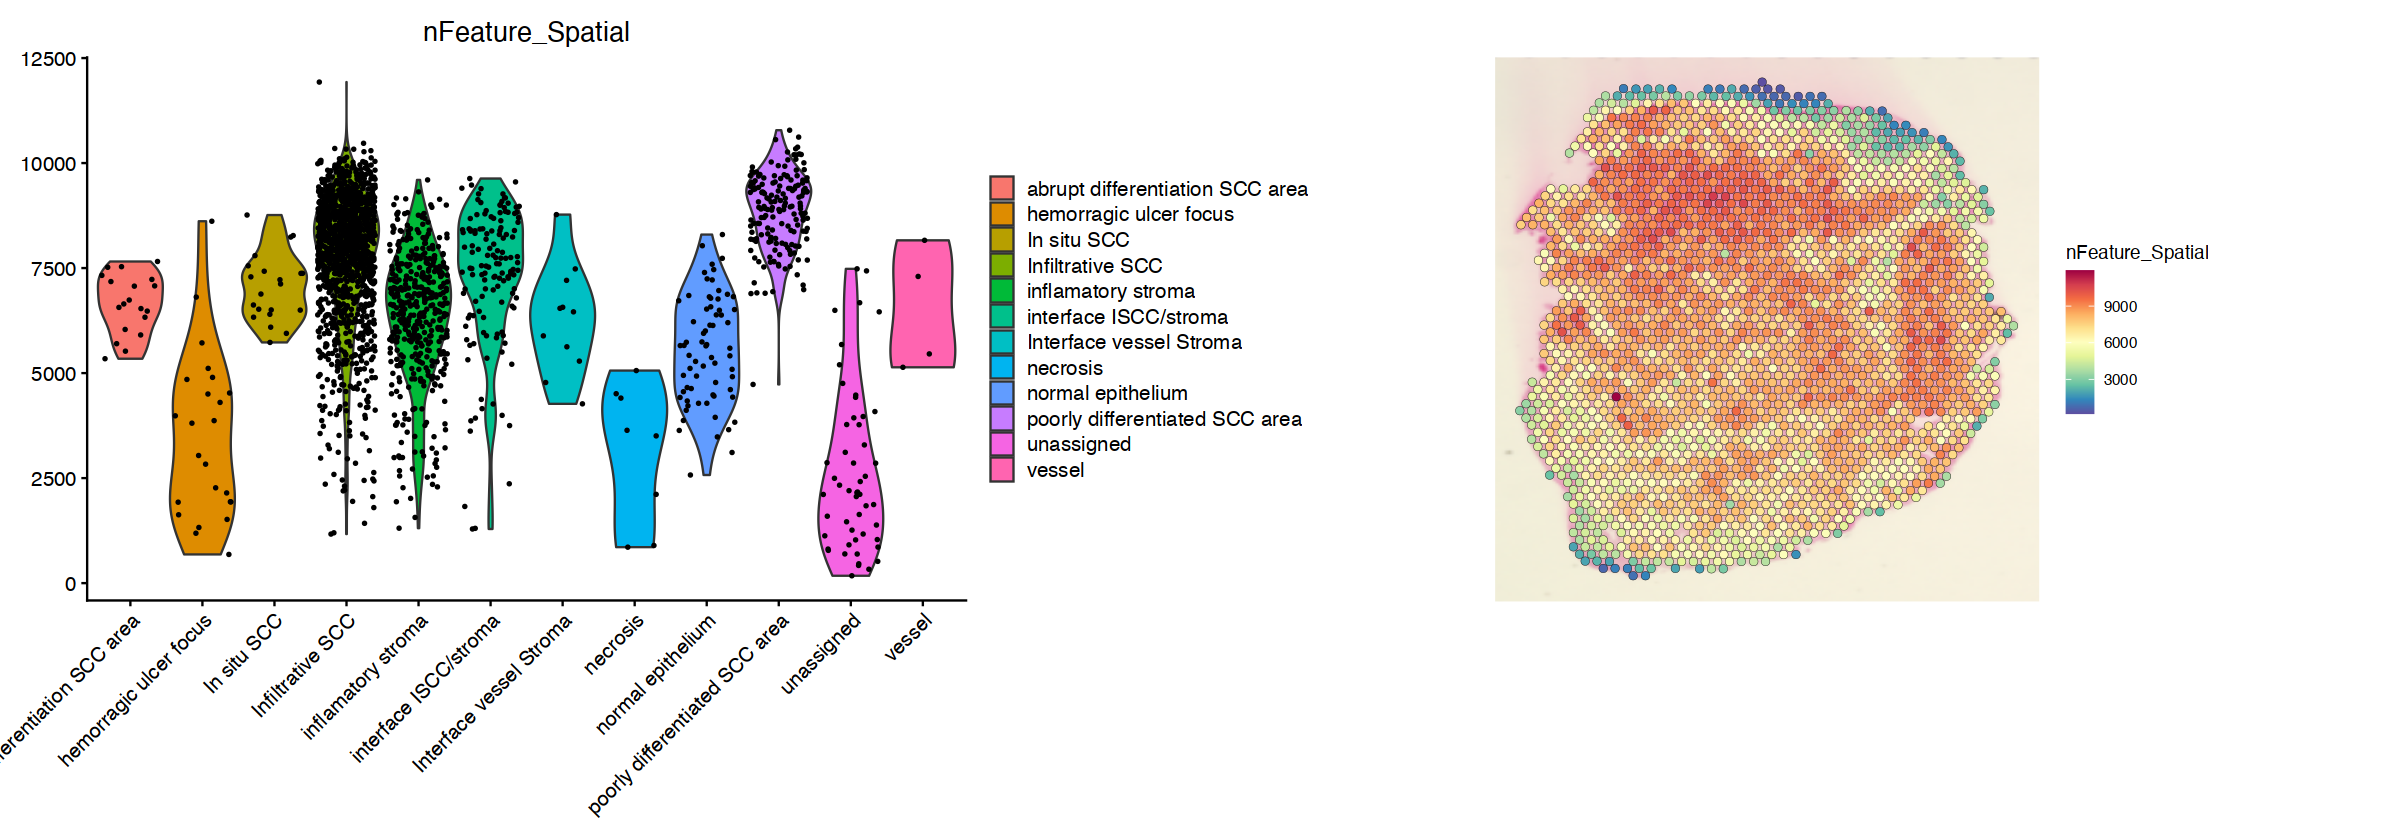

In [9]:
options(repr.plot.width = 20, repr.plot.height = 7)
wrap_plots(plot1, plot2)
wrap_plots(plot3, plot4)

## TCGA-based CNA+expression spaCET deconvolution

In [10]:
SpaCET_obj <- convert.Seurat(obj)

[1] "0 spots are removed."
[1] "2204 spots are kept."


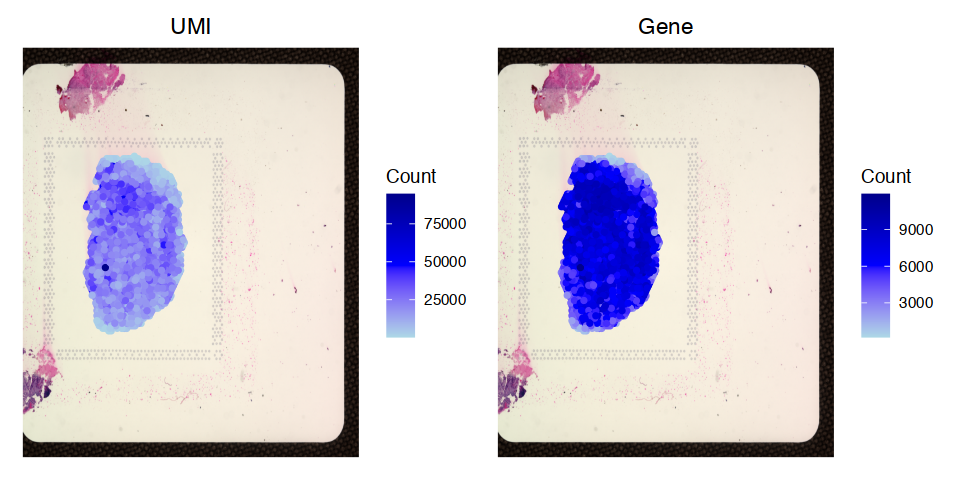

In [11]:
SpaCET_obj <- SpaCET.quality.control(SpaCET_obj)
options(repr.plot.width = 8, repr.plot.height = 4)
SpaCET.visualize.spatialFeature(SpaCET_obj, spatialType = "QualityControl", spatialFeatures=c("UMI","Gene"))

In [12]:
SpaCET_obj <- SpaCET.deconvolution(SpaCET_obj, cancerType="HNSC", coreNo=1)

[1] "Stage 1. Infer malignant cell fraction."
[1] "Stage 1 - Step 1. Clustering."


Warning message:
“package ‘Matrix’ was built under R version 4.2.3”


[1] "Stage 1 - Step 2. Find tumor clusters."
[1] "                  > Use CNA signature: HNSC"
[1] "Stage 1 - Step 3. Infer malignant cells."
[1] "Stage 2. Hierarchically deconvolve non-malignant cell fraction."
[1] "Stage 2 - Level 1. Estimate the major lineage."
[1] "Stage 2 - Level 2. Estimate the sub lineage."


In [13]:
SpaCET_obj@results$deconvolution$propMat[1:13,1:6]

47x71        49x43        28x86        51x41        67x55       
Malignant   7.862372e-01 7.042460e-01 2.884334e-01 1.874085e-01 6.734993e-02
CAF         5.180743e-02 6.460217e-02 1.037491e-01 5.193159e-01 5.487440e-01
Endothelial 2.745116e-02 7.446003e-02 2.728479e-02 4.654161e-02 2.095367e-01
Plasma      1.674682e-02 8.087783e-08 1.272769e-02 1.580214e-03 2.798907e-03
B cell      4.927843e-07 1.813102e-06 1.233538e-02 7.221386e-06 5.745121e-06
T CD4       1.196220e-05 4.511230e-07 7.841735e-02 5.183198e-06 1.964775e-03
T CD8       4.867894e-07 2.880862e-07 8.309418e-07 2.871083e-05 3.145019e-07
NK          3.449001e-09 5.264873e-07 7.429265e-06 2.097969e-06 6.343544e-09
cDC         7.705822e-03 2.145602e-05 1.247545e-01 7.796423e-06 5.832765e-07
pDC         4.646112e-03 1.891727e-02 8.885980e-02 7.427031e-02 7.498368e-03
Macrophage  3.523450e-02 9.323784e-02 2.248861e-02 3.064548e-02 1.328065e-01
Mast        4.805492e-05 7.216780e-05 1.267574e-03 1.521700e-07 3.527904e-03
Neutrophil  4.709394e-09 6.741038e-03 2.396733e-01 1.401811e-01 2.575692e-02
            38x104      
Malignant   7.408492e-01
CAF         3.506743e-08
Endothelial 6.985626e-07
Plasma      3.240615e-03
B cell      2.372215e-04
T CD4       5.202394e-06
T CD8       4.702601e-08
NK          6.016011e-03
cDC         2.129403e-02
pDC         2.120229e-02
Macrophage  1.024287e-02
Mast        3.975927e-02
Neutrophil  5.362471e-02

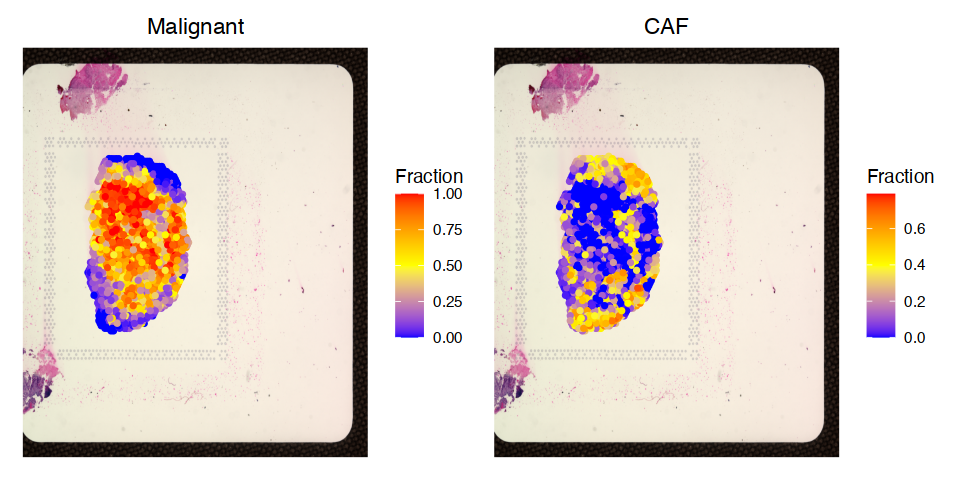

In [14]:
SpaCET.visualize.spatialFeature(
  SpaCET_obj, 
  spatialType = "CellFraction", 
  spatialFeatures=c("Malignant","CAF")
)

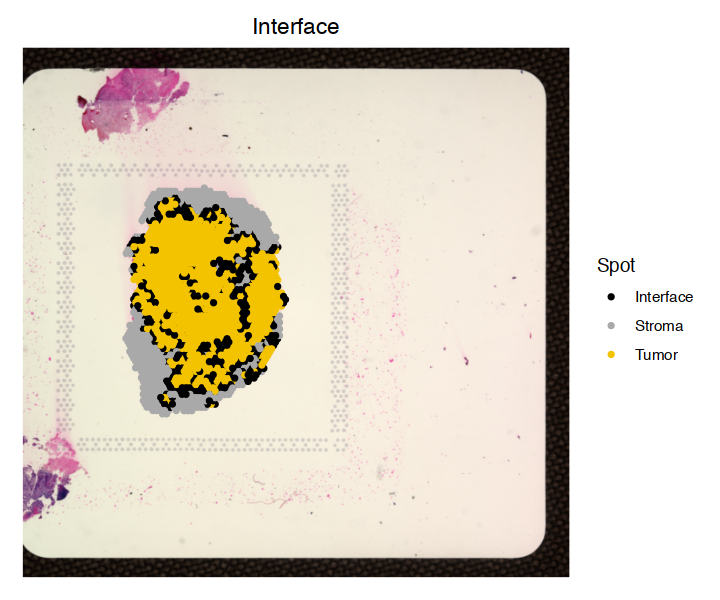

In [15]:
# Identify the Tumor-Stroma Interface
SpaCET_obj <- SpaCET.identify.interface(SpaCET_obj)
# Visualize the Interface
options(repr.plot.width = 6, repr.plot.height = 5)
SpaCET.visualize.spatialFeature(SpaCET_obj, spatialType = "Interface", spatialFeature = "Interface")

In [ ]:
# further deconvolve malignant cell states
SpaCET_obj <- SpaCET.deconvolution.malignant(SpaCET_obj, coreNo = 1)

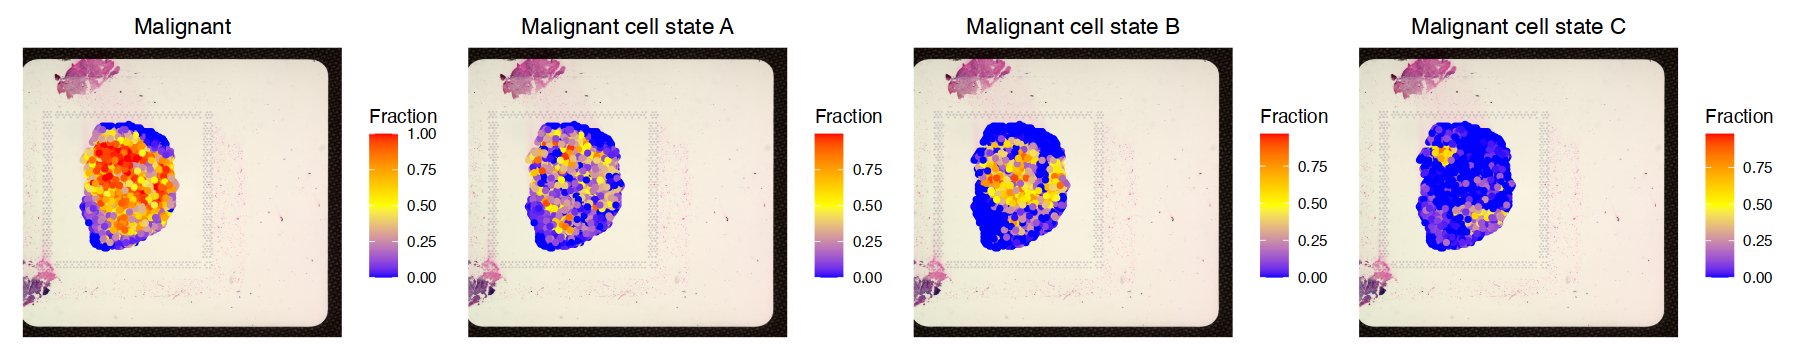

In [18]:
options(repr.plot.width = 15, repr.plot.height = 3)
SpaCET.visualize.spatialFeature( 
  SpaCET_obj, 
  spatialType = "CellFraction", 
  spatialFeatures=c("Malignant","Malignant cell state A","Malignant cell state B","Malignant cell state C"), 
  nrow=1
)

In [19]:
# Add deconvolution results as propMatFromSpaCET assay to the Seurat object
obj <- addTo.Seurat(SpaCET_obj, obj)
head(obj$propMatFromSpaCET@data, 3)

AACACTTGGCAAGGAA-1 AACAGGATTCATAGTT-1 AACAGGTTATTGCACC-1
Malignant   0.78623719         0.70424597         0.28843338        
CAF         0.05180743         0.06460217         0.10374906        
Endothelial 0.02745116         0.07446003         0.02728479        
            AACAGGTTCACCGAAG-1 AACATCTAATGACCGG-1 AACCAAGGTATCAGGC-1
Malignant   0.18740849         0.06734993         7.408492e-01      
CAF         0.51931592         0.54874403         3.506743e-08      
Endothelial 0.04654161         0.20953669         6.985626e-07      
            AACCACTGCCATAGCC-1 AACCAGAATCAGACGT-1 AACCGCCAGACTACTT-1
Malignant   9.780381e-01       0.49633968         0.56368960        
CAF         2.410500e-07       0.15393545         0.36747871        
Endothelial 1.267138e-05       0.01770802         0.03711265        
            AACCTGACAGTGCCGC-1 ⋯ TGTTACCTATTGGACA-1 TGTTCAGAACGGTGTA-1
Malignant   0.06295754         ⋯ 8.740849e-01       0.73499268        
CAF         0.56248189         ⋯ 1.265002e-07       0.13864837        
Endothelial 0.24905997         ⋯ 1.236422e-06       0.01147837        
            TGTTCATAGTATGACG-1 TGTTCCTCACATTAAT-1 TGTTCTGCTCTGTCGT-1
Malignant   0.06295754         8.462665e-01       0.61346999        
CAF         0.57405185         9.289249e-07       0.09955506        
Endothelial 0.08089661         1.049998e-06       0.06790692        
            TGTTGCGTCCAAGATT-1 TGTTGGAACCTTCCGC-1 TGTTGGAACGAGGTCA-1
Malignant   0.19180088         0.76281113         0.45680820        
CAF         0.64087429         0.09847690         0.37237565        
Endothelial 0.06443401         0.04328443         0.08624889        
            TGTTGGATGGACTTCT-1 TGTTGGCCAGACCTAC-1
Malignant   0.91361640         0.64714495        
CAF         0.02826441         0.14618739        
Endothelial 0.02104812         0.04393422

In [20]:
# Access the Tumor-Stroma Interface results to the Seurat object's metadata
interface_df <- as.data.frame(t(SpaCET_obj@results$CCI$interface))

In [21]:
head(interface_df)

Interface
47x71  Tumor    
49x43  Tumor    
28x86  Stroma   
51x41  Interface
67x55  Stroma   
38x104 Tumor

In [22]:
obj[['interface']] <- interface_df$Interface
head(obj[[]], 10)

orig.ident   nCount_Spatial nFeature_Spatial response
AACACTTGGCAAGGAA-1 19h1257-1_PP 30707          8949             NR      
AACAGGATTCATAGTT-1 19h1257-1_PP 26333          8419             NR      
AACAGGTTATTGCACC-1 19h1257-1_PP 16632          6095             NR      
AACAGGTTCACCGAAG-1 19h1257-1_PP 20990          6931             NR      
AACATCTAATGACCGG-1 19h1257-1_PP 22763          7336             NR      
AACCAAGGTATCAGGC-1 19h1257-1_PP 16951          6843             NR      
AACCACTGCCATAGCC-1 19h1257-1_PP 37095          9652             NR      
AACCAGAATCAGACGT-1 19h1257-1_PP 27374          8500             NR      
AACCGCCAGACTACTT-1 19h1257-1_PP 21830          7737             NR      
AACCTGACAGTGCCGC-1 19h1257-1_PP 11770          5355             NR      
                   labels   percent.mito low_outliers high_outliers
AACACTTGGCAAGGAA-1 Selected 2.035367     FALSE        FALSE        
AACAGGATTCATAGTT-1 Selected 2.308890     FALSE        FALSE        
AACAGGTTATTGCACC-1 Selected 1.160414     FALSE        FALSE        
AACAGGTTCACCGAAG-1 Selected 1.257742     FALSE        FALSE        
AACATCTAATGACCGG-1 Selected 1.287177     FALSE        FALSE        
AACCAAGGTATCAGGC-1 Selected 3.368533     FALSE        FALSE        
AACCACTGCCATAGCC-1 Selected 2.439682     FALSE        FALSE        
AACCAGAATCAGACGT-1 Selected 1.950756     FALSE        FALSE        
AACCGCCAGACTACTT-1 Selected 1.749885     FALSE        FALSE        
AACCTGACAGTGCCGC-1 Selected 1.257434     FALSE        FALSE        
                   LOG_low_outliers LOG_high_outliers ⋯ SCT_snn_res.0.3
AACACTTGGCAAGGAA-1 FALSE            FALSE             ⋯ 0              
AACAGGATTCATAGTT-1 FALSE            FALSE             ⋯ 0              
AACAGGTTATTGCACC-1 FALSE            FALSE             ⋯ 2              
AACAGGTTCACCGAAG-1 FALSE            FALSE             ⋯ 2              
AACATCTAATGACCGG-1 FALSE            FALSE             ⋯ 1              
AACCAAGGTATCAGGC-1 FALSE            FALSE             ⋯ 0              
AACCACTGCCATAGCC-1 FALSE            FALSE             ⋯ 0              
AACCAGAATCAGACGT-1 FALSE            FALSE             ⋯ 1              
AACCGCCAGACTACTT-1 FALSE            FALSE             ⋯ 1              
AACCTGACAGTGCCGC-1 FALSE            FALSE             ⋯ 1              
                   SCT_snn_res.0.5 S.Score     G2M.Score    Phase old.ident
AACACTTGGCAAGGAA-1 0                0.05958682  0.321202942 G2M   0        
AACAGGATTCATAGTT-1 0               -0.05725855  0.140574388 G2M   0        
AACAGGTTATTGCACC-1 3               -0.37401155 -0.243967759 G1    3        
AACAGGTTCACCGAAG-1 3               -0.37595794 -0.289638662 G1    3        
AACATCTAATGACCGG-1 2               -0.32464648 -0.275677495 G1    2        
AACCAAGGTATCAGGC-1 7                0.03020539 -0.122109011 S     7        
AACCACTGCCATAGCC-1 1                0.23181981  0.033571624 S     1        
AACCAGAATCAGACGT-1 2               -0.01713912 -0.010217463 G1    2        
AACCGCCAGACTACTT-1 0               -0.02611881  0.003792991 G2M   0        
AACCTGACAGTGCCGC-1 2               -0.15520014 -0.215534806 G1    2        
                   Barcode            Cell_Phase pathologist.annotations       
AACACTTGGCAAGGAA-1 AACACTTGGCAAGGAA-1 unassigned Infiltrative SCC              
AACAGGATTCATAGTT-1 AACAGGATTCATAGTT-1 unassigned Infiltrative SCC              
AACAGGTTATTGCACC-1 AACAGGTTATTGCACC-1 unassigned Infiltrative SCC              
AACAGGTTCACCGAAG-1 AACAGGTTCACCGAAG-1 unassigned inflamatory stroma            
AACATCTAATGACCGG-1 AACATCTAATGACCGG-1 unassigned Infiltrative SCC              
AACCAAGGTATCAGGC-1 AACCAAGGTATCAGGC-1 unassigned Infiltrative SCC              
AACCACTGCCATAGCC-1 AACCACTGCCATAGCC-1 unassigned Infiltrative SCC              
AACCAGAATCAGACGT-1 AACCAGAATCAGACGT-1 unassigned poorly differentiated SCC area
AACCGCCAGACTACTT-1 AACCGCCAGACTACTT-1 unassigned interface ISCC/stroma         
AACCTGACAGTGCCGC-1 AACCTGACAGTGCCGC-1 un

In [23]:
saveRDS(SpaCET_obj,"19h1257-1-PP_spaCET.rds")

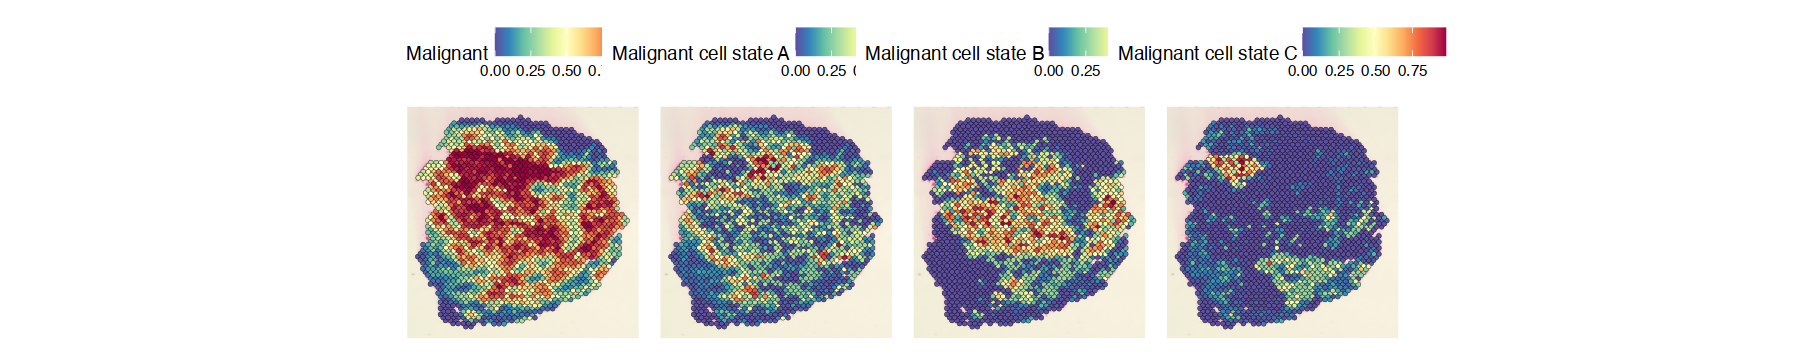

In [25]:
Seurat::DefaultAssay(obj) <- "propMatFromSpaCET"
Seurat::SpatialFeaturePlot(obj, features = c("Malignant", "Malignant cell state A","Malignant cell state B",
                                            "Malignant cell state C"),
                          pt.size=3, ncol=4)

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


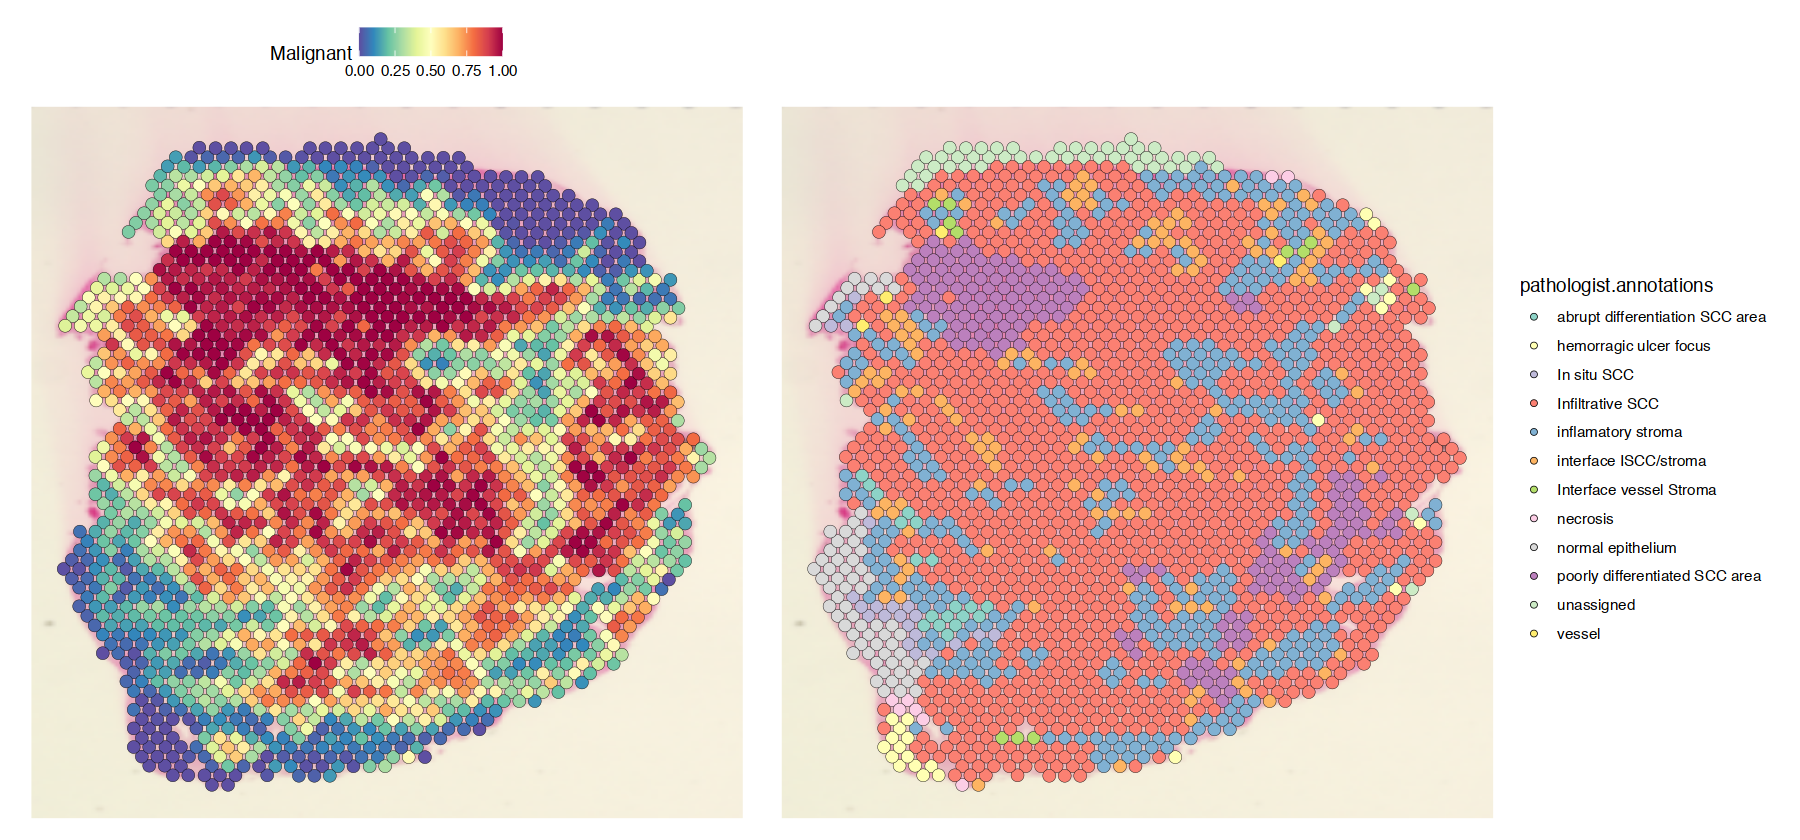

In [27]:
options(repr.plot.width = 15, repr.plot.height = 7)
plot1 <- Seurat::SpatialFeaturePlot(obj, features = c("Malignant"),pt.size=3)
plot2 <- SpatialPlot(obj, group.by = "pathologist.annotations",pt.size=3) + 
scale_fill_brewer(palette="Set3") +
theme(legend.position = "right") 
wrap_plots(plot1, plot2)

In [28]:
spaCET.props = as.data.frame(t(obj[["propMatFromSpaCET"]]@data))

In [29]:
obj <- AddMetaData(object = obj, metadata = spaCET.props)

In [30]:
#Assign unique label for cell type: Malignant if score>0.7, else second highest proportion label
get_cell_type <- function(proportions) {
    max_idx <- which.max(proportions)
    if (names(proportions)[max_idx] == 'Malignant') {
        if (proportions[max_idx] > 0.7) {
            return(names(proportions)[max_idx])
        } else {
            return('Epithelial')  # Assign 'Epithelial' as the label
        }
    } else {
        return(names(proportions)[max_idx])
    }
}


In [32]:
max_cell_type <- apply(obj@meta.data[, c("Malignant","CAF","Endothelial","Plasma","B cell","T CD4","T CD8","NK","cDC","pDC","Macrophage","Mast","Neutrophil","Unidentifiable","B cell naive","B cell non-switched memory","B cell switched memory","B cell exhausted","T CD4 naive","Th1","Th2","Th17","Tfh","Treg","T CD8 naive","T CD8 central memory","T CD8 effector memory","T CD8 effector","T CD8 exhausted","cDC1 CLEC9A","cDC2 CD1C","cDC3 LAMP3","Macrophage M1","Macrophage M2","Macrophage other","Malignant cell state A","Malignant cell state B","Malignant cell state C")], 1, function(x) get_cell_type(x))

In [33]:
obj@meta.data$spaCET.cellType <- max_cell_type

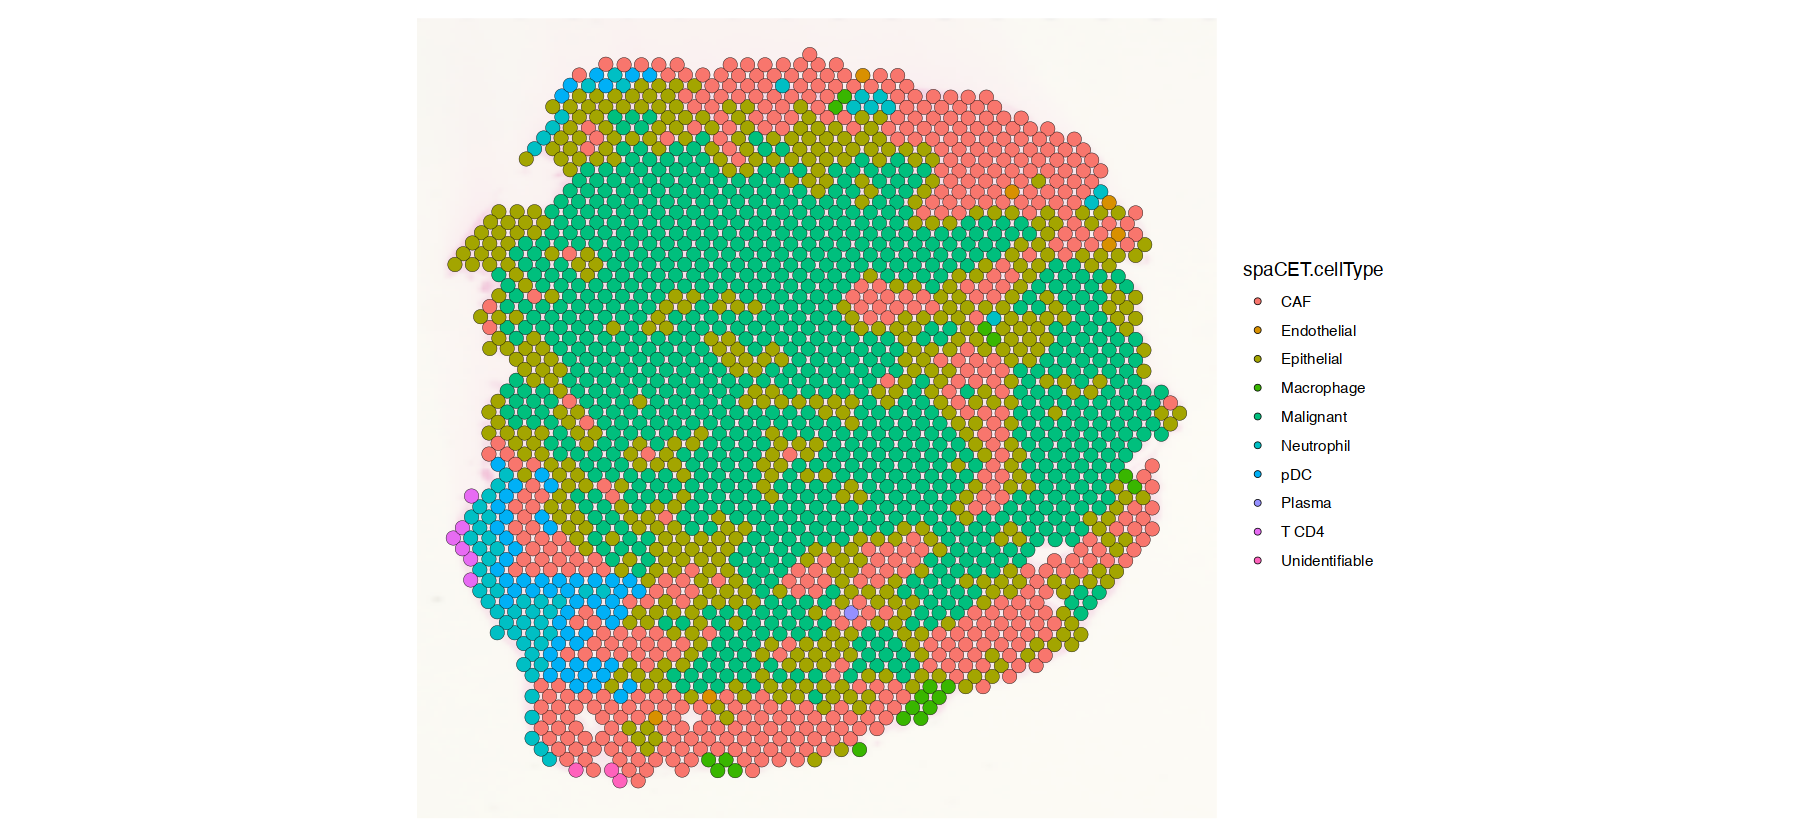

In [40]:
SpatialDimPlot(obj, label = F,group.by = 'spaCET.cellType', label.size = 3, pt.size=3,image.alpha=0.3)

In [43]:
# Normally I would correct based on pathologist annotations but this slide needs to be reviewed!
#obj$is_cancer_cell <- ifelse(obj$Malignant > 0.65 & obj$pathologist.annotations %in% c("Infiltrative SCC","In situ Carcinoma") , "1", "0")

In [41]:
obj$is_cancer_cell <- ifelse(obj$Malignant > 0.7, "1", "0")

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


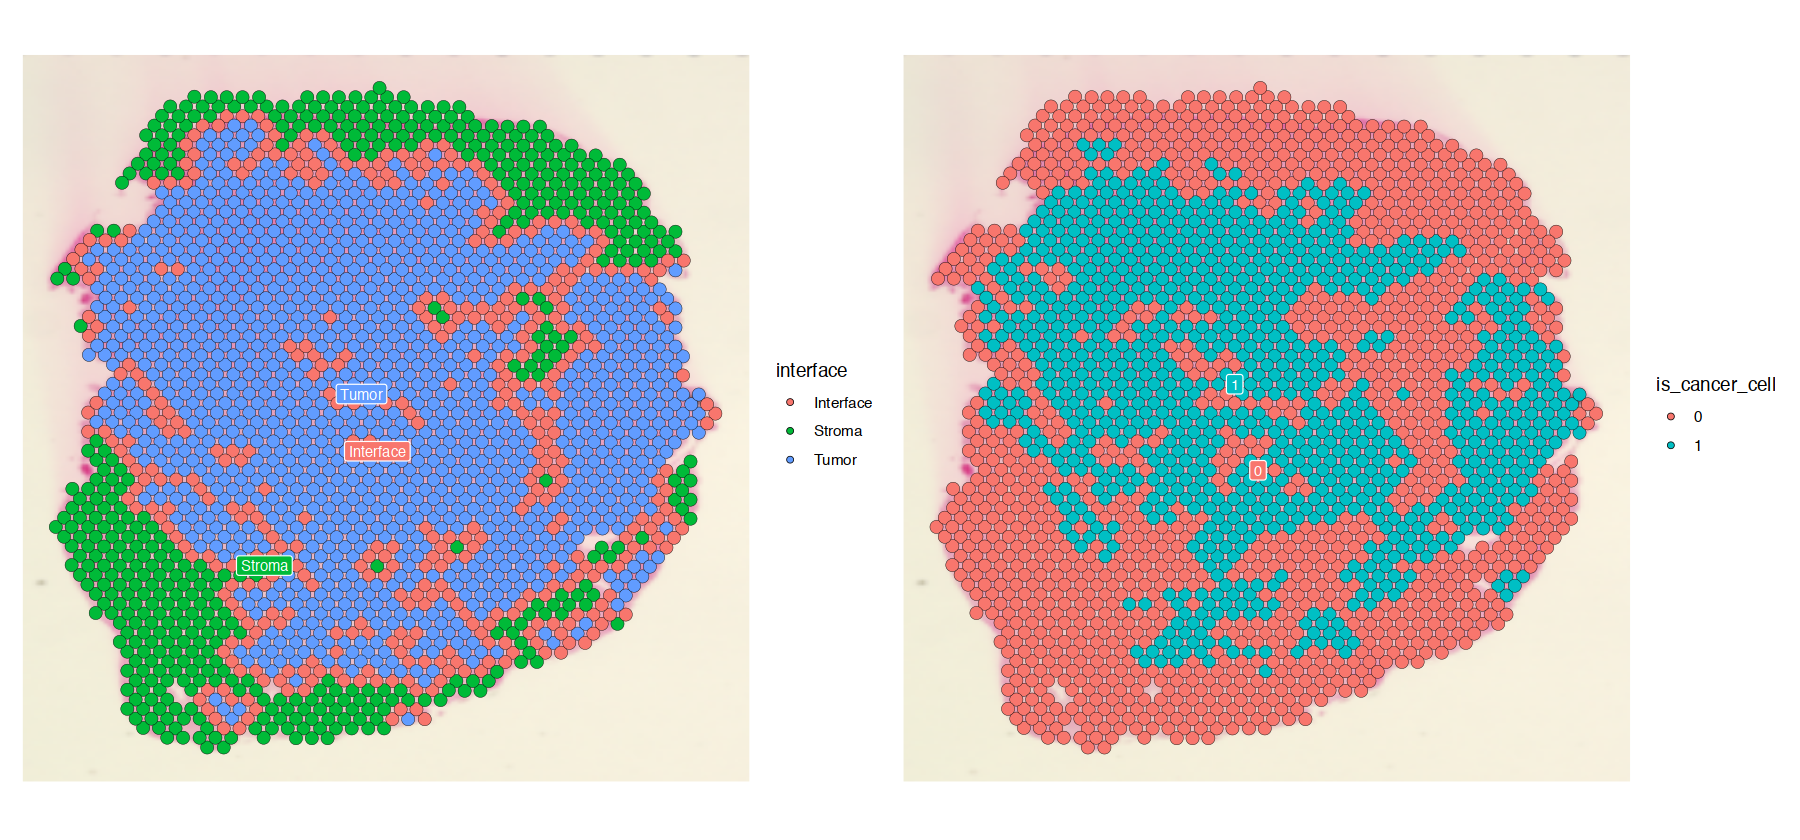

In [42]:
plot1 <- SpatialDimPlot(obj, label = TRUE,group.by = 'is_cancer_cell', label.size = 3, pt.size=3)
plot2 <- SpatialDimPlot(obj, label = TRUE,group.by = 'interface', label.size = 3, pt.size=3)
#plot3 <- SpatialPlot(obj, group.by = "pathologist.annotations", label.size = 3)
#wrap_plots(plot2,plot1,plot3)
wrap_plots(plot2,plot1)

In [43]:
saveRDS(obj,"19h1257-1-PP_deconvoluted.rds")

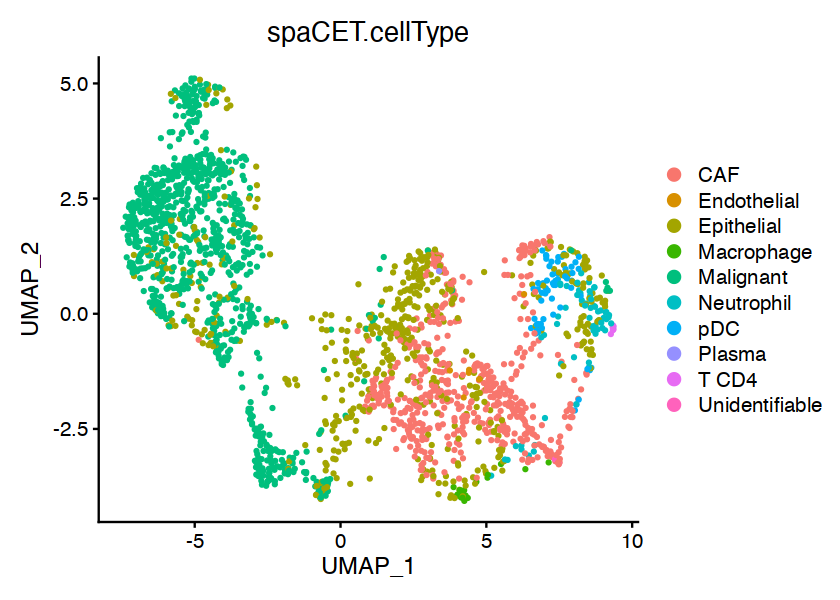

In [45]:
options(repr.plot.width = 7, repr.plot.height = 5)
DimPlot(obj, reduction = "umap", group.by = "spaCET.cellType")